In [15]:
import os
import random
import torch
import numpy as np
import pickle as pkl
from analysis import *
import argparse
from sys import platform
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
torch.backends.cudnn.deterministics = True
torch.set_num_threads(1)

In [17]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())


print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA GeForce RTX 3090


In [18]:
# iv: image option
length = 440
channel = 128
min_CNN = 200
n_classes = 40
classes = range(n_classes)


In [19]:
if platform == "linux" or platform == "linux2":
    torch_models_dir = r"/media/mountHDD1/LanxHuyen/CVPR2017"
elif platform == "win32":
    torch_models_dir = r"D:\Data\CVPR2021-02785\CVPR2021-02785\preprocessed\torch_models"
block_splits_all = '/media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth' 
eeg_raw = '/media/mountHDD1/LanxHuyen/CVPR2017/eeg_5_95_std.pth'
# block_splits_all, block_splits_single, eeg_14_70, eeg_55_95, eeg_5_95, eeg_raw = os.listdir(torch_models_dir)
# print(os.listdir(torch_models_dir))

In [20]:
# eeg_dataset = os.path.join(torch_models_dir, eeg_5_95)
# splits_all_path = os.path.join(torch_models_dir, block_splits_all)
eeg_dataset = eeg_raw
splits_all_path = block_splits_all

print(eeg_dataset,'\n', splits_all_path)

/media/mountHDD1/LanxHuyen/CVPR2017/eeg_5_95_std.pth 
 /media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth


In [21]:
splits_all = torch.load(splits_all_path)
# splits_single = torch.load(splits_single_path)

In [22]:
print(len(splits_all['splits']))
print(len(splits_all['splits'][0]))

print(len(splits_all['splits'][5]['train']))
print(len(splits_all['splits'][5]['val']))
print(len(splits_all['splits'][5]['test']))
print(splits_all['splits'][0]['train'][:40])
print(splits_all['splits'][1]['train'][:40])
print(splits_all['splits'][2]['train'][:10])
print(splits_all['splits'][3]['train'][:10])


6
3
7984
1996
1985
[0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 29, 33, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 51, 52, 54, 55]
[1, 2, 3, 4, 6, 8, 9, 12, 13, 20, 25, 26, 27, 28, 30, 32, 33, 35, 37, 38, 39, 40, 44, 45, 46, 50, 52, 54, 56, 58, 59, 60, 62, 65, 68, 72, 73, 74, 76, 81]
[2, 3, 4, 5, 6, 7, 8, 10, 11, 13]
[1, 2, 4, 7, 9, 10, 12, 13, 14, 15]


In [166]:
eeg_loaded = torch.load(eeg_dataset)

In [167]:
print(len(eeg_loaded))
print(eeg_loaded.keys())
dataset, labels, images = [eeg_loaded[k] for k in eeg_loaded.keys()]
print(len(labels))
print(len(images))
print(len(dataset))
print(*labels)
print(images[0])
print(dataset[0]['eeg'].shape)
print(dataset[1950])
#Trial 0-1995 - subject 4
#Trial 1996 - 3980 - subject 1
#Trial 3981 - 5976 - subject 6
#Trial 5977 - 7972 - subject 3
#Trial 7973 - 9968 - subject 2
#Trial 9969 - 11964 - subject 5

3
dict_keys(['dataset', 'labels', 'images'])
40
1996
11965
n02389026 n03888257 n03584829 n02607072 n03297495 n03063599 n03792782 n04086273 n02510455 n11939491 n02951358 n02281787 n02106662 n04120489 n03590841 n02992529 n03445777 n03180011 n02906734 n07873807 n03773504 n02492035 n03982430 n03709823 n03100240 n03376595 n03877472 n03775071 n03272010 n04069434 n03452741 n03792972 n07753592 n13054560 n03197337 n02504458 n02690373 n03272562 n04044716 n02124075
n02951358_31190
torch.Size([128, 500])
{'eeg': tensor([[ 0.0144, -0.0790, -0.1815,  ..., -0.0770, -0.0619, -0.0257],
        [ 0.0182, -0.0712, -0.1688,  ..., -0.0241, -0.0334, -0.0179],
        [-0.0080, -0.0906, -0.1497,  ..., -0.1995, -0.0860,  0.0092],
        ...,
        [ 0.0033, -0.1479, -0.2861,  ...,  0.0940,  0.0406, -0.0049],
        [-0.0047, -0.0076, -0.0117,  ..., -0.0048, -0.0059, -0.0056],
        [ 0.0031, -0.0257, -0.0693,  ..., -0.0478, -0.0398, -0.0109]]), 'image': 1950, 'label': 16, 'subject': 4}


In [168]:
import numpy as np
import torch
from torch import nn
from torchvision import transforms

In [170]:
# class SmoothedHeatmap(torch.nn.Module):
#     def __init__(self, window_size=10):
#         super(SmoothedHeatmap, self).__init__()
#         self.window_size = window_size

#     def forward(self, signal):
#         # Compute the average of the signal over the window
#         smoothed_signal = torch.mean(signal, dim=1)

#         # Compute the heatmap
#         heatmap = smoothed_signal / smoothed_signal.max()

#         return heatmap
def SmoothedHeatmap(heatmap, kernel_size=(3, 3), sigma=(1, 1)):
    """
    Smooth a heatmap image using a Gaussian filter.

    Args:
        heatmap: A torch tensor of shape (output_shape[0], output_shape[1]).
        kernel_size: The size of the Gaussian filter kernel.
        sigma: The standard deviation of the Gaussian filter kernel.

    Returns:
        A torch tensor of shape (output_shape[0], output_shape[1]).
    """

    # Create a Gaussian filter
    gaussian_filter = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

    # Apply the Gaussian filter to the heatmap image
    smoothed_heatmap = gaussian_filter(heatmap)

    return smoothed_heatmap

In [173]:
def process_method_2(eeg_data, time_low=20, time_high=460, output_shape=(512, 440)):
    """
    Transform EEG data to heatmap image using smoothed heatmap algorithm without convolution.

    Args:
        eeg_data: A torch tensor of shape (channels, time_samples).
        time_low: The start time of the window to be transformed.
        time_high: The end time of the window to be transformed.
        output_shape: The desired output shape of the heatmap image.

    Returns:
        A torch tensor of shape (output_shape[0], output_shape[1]).
    """

    eeg_data = eeg_data[:, time_low:time_high]
    # smoothed_heatmap = SmoothedHeatmap()
    heatmap = SmoothedHeatmap(eeg_data)
    resized_image = torch.nn.functional.interpolate(heatmap.unsqueeze(0).unsqueeze(0).unsqueeze(0), size=output_shape, mode='bilinear', align_corners=True).squeeze(0)

    return resized_image

In [174]:
for sample in dataset:
    sample['eeg'] = process_method_2(sample['eeg'])

IndexError: tuple index out of range

In [164]:
print("Processed Images Shape:", dataset[0]['eeg'].size())

Processed Images Shape: torch.Size([1, 512, 440])


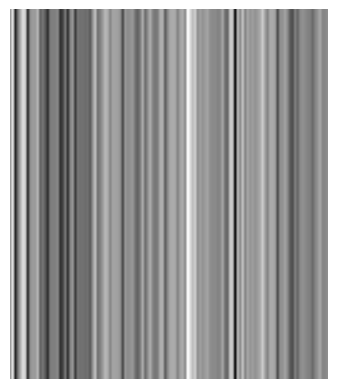

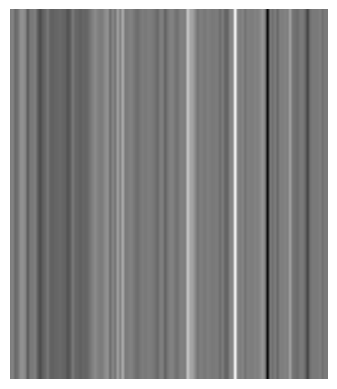

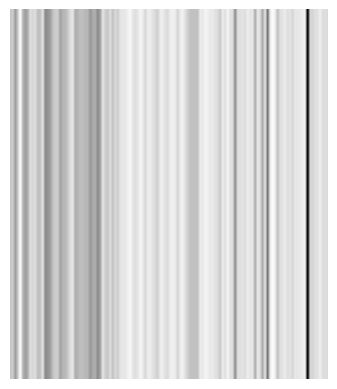

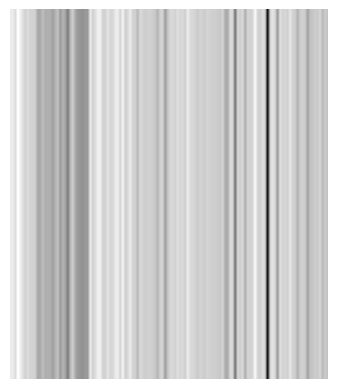

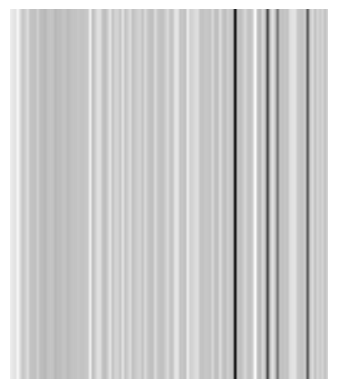

In [165]:
import cv2
import os
import matplotlib.pyplot as plt
# Choose an index for the image you want to visualize
image_index = 2  # Change this to the index you want to visualize

# Retrieve the processed image tensor from the dataset
for image_index in range (5):
    processed_image_tensor = dataset[image_index]['eeg']

# Convert the processed image tensor to a NumPy array
    processed_image_np = processed_image_tensor.cpu().numpy()

# Convert the NumPy array to an image in the range [0, 255]
    processed_image_np = processed_image_np.transpose(1, 2, 0)  # Channels-last format
    processed_image_np = processed_image_np.squeeze()  # Remove singleton dimensions
    # processed_image_np = processed_image_np.astype('uint8')

# Using Matplotlib
    plt.imshow(processed_image_np, cmap='gray')  # Display as grayscale
    plt.axis('off')
    plt.show()

In [25]:
import os
import torch
import pywt
import numpy as np
import cv2
import torch.nn.functional as F
def process_method_1(eeg_data, time_low=20, time_high=460, output_shape=(512, 440)):
    eeg_data = eeg_data[:, time_low:time_high]
    normalized_data = (eeg_data - eeg_data.min()) / (eeg_data.max() - eeg_data.min())
    grayscale_images = (normalized_data * 255).to(torch.uint8)
    grayscale_images = grayscale_images.unsqueeze(0).unsqueeze(0) # (1, 1, h, w)
    resized_images = F.interpolate(grayscale_images, size=output_shape, mode='bilinear', align_corners=True)
    resized_images = resized_images.squeeze(0).squeeze(0)
    resized_images = torch.tensor(resized_images, dtype=torch.float32)
    return resized_images
# Apply method 1 to each tensor in eeg_tensors
for sample in dataset:
    sample['eeg'] = process_method_1(sample['eeg'])


/tmp/ipykernel_152427/3732286957.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resized_images = torch.tensor(resized_images, dtype=torch.float32)


In [31]:
import numpy as np
from scipy.stats import kurtosis, skew
import logging
import torch
import matplotlib.pyplot as plt

/tmp/ipykernel_152427/3732286957.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resized_images = torch.tensor(resized_images, dtype=torch.float32)


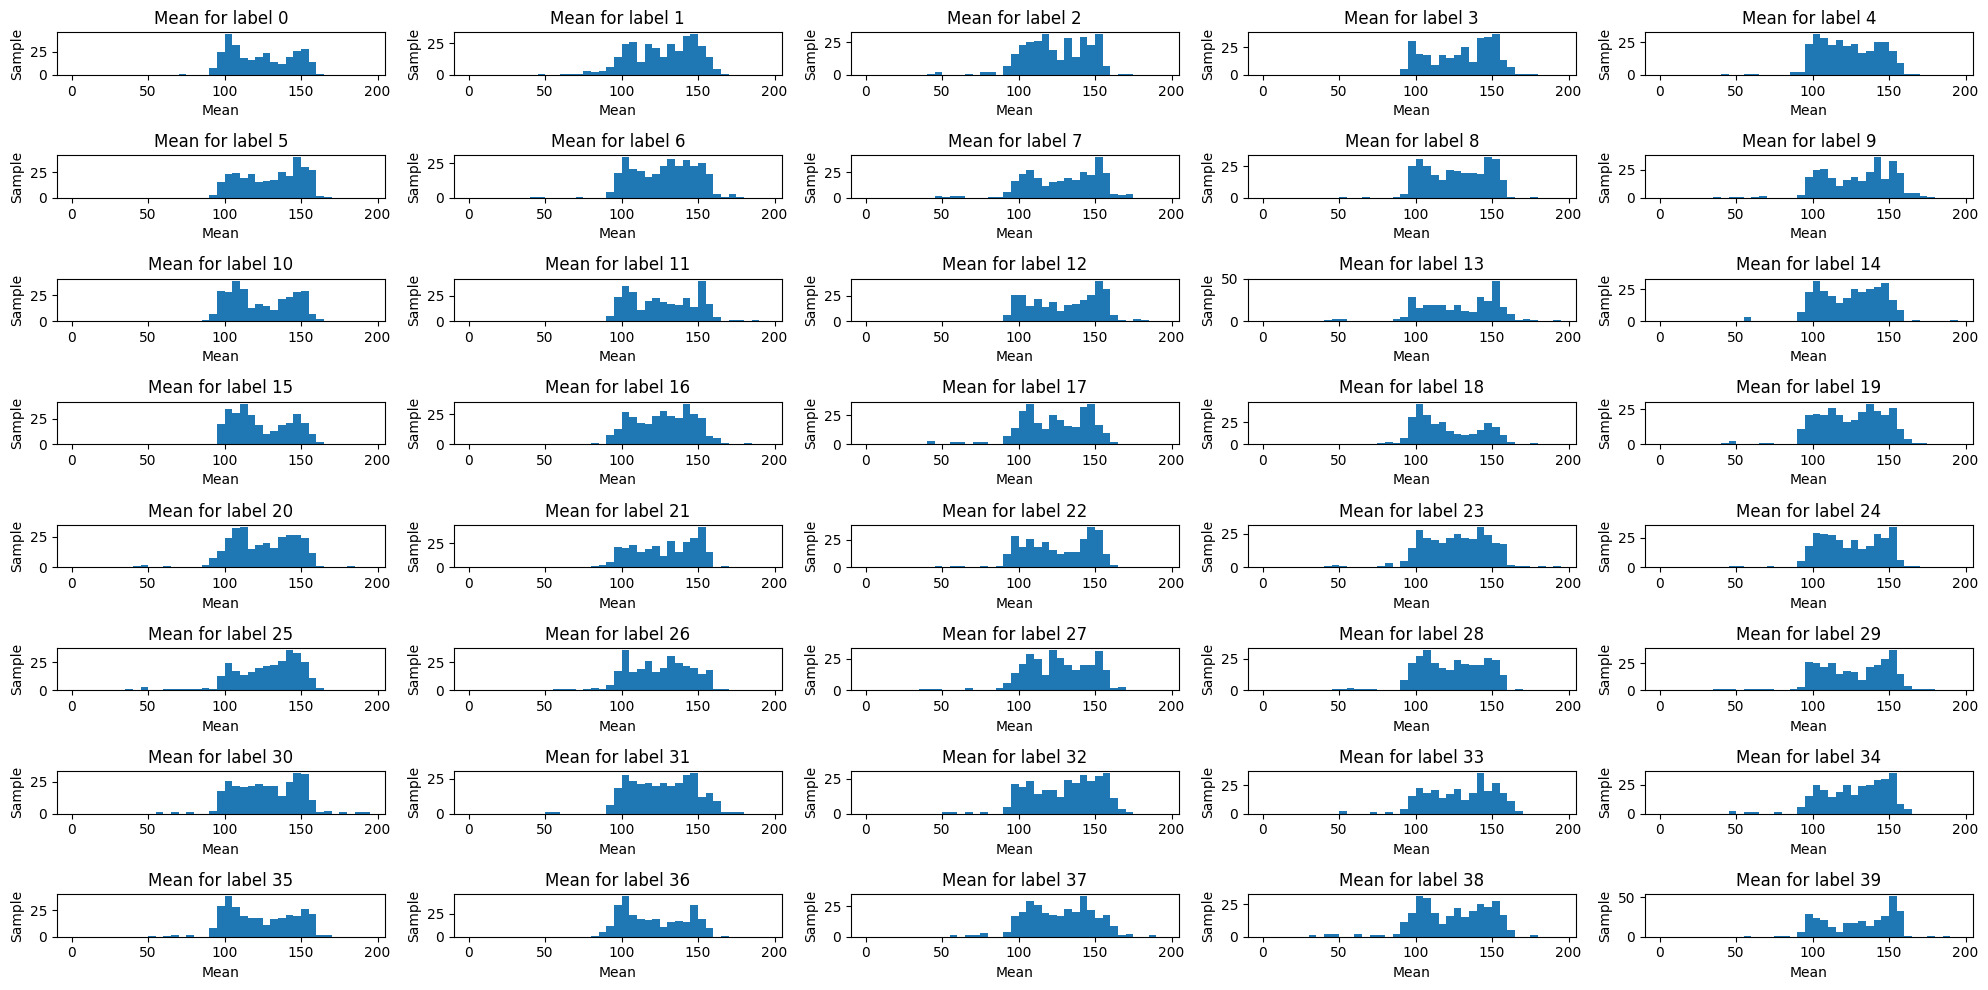

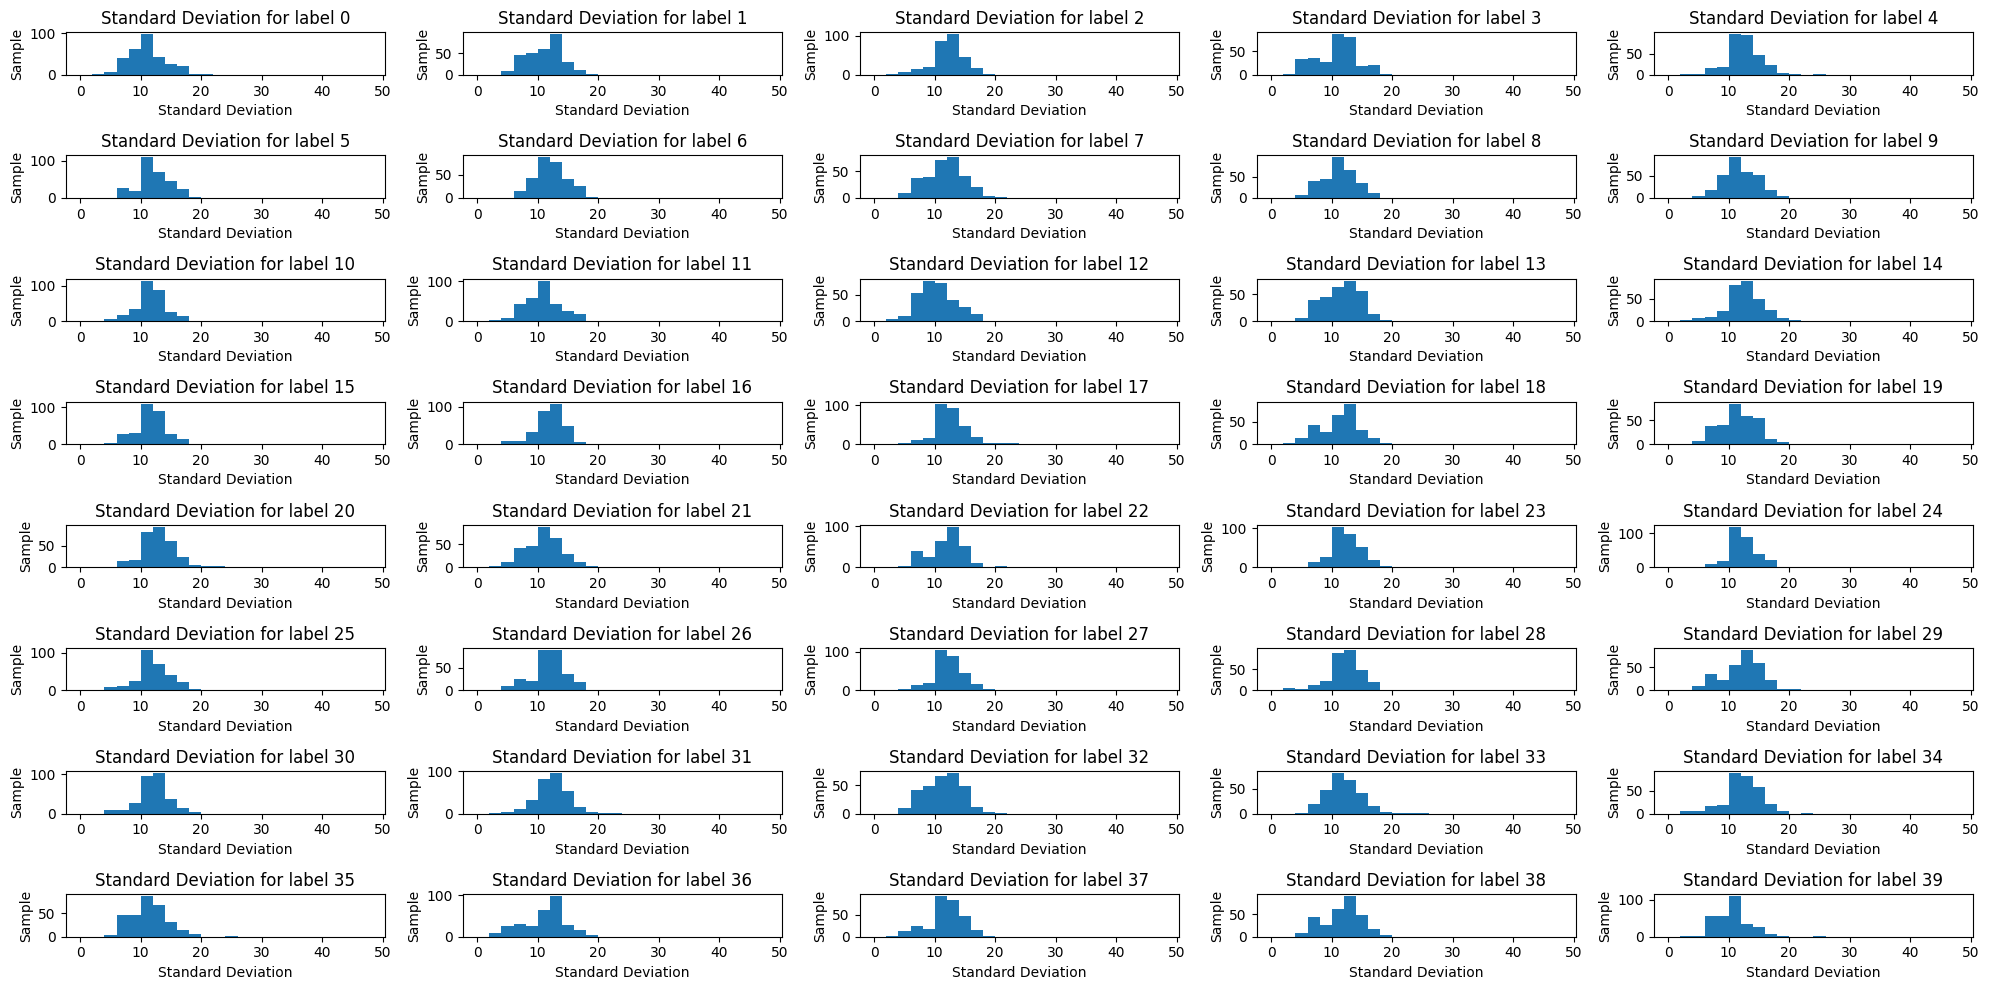

In [50]:
# Initialize dictionaries to store statistics for each label
label_statistics = {}

# Define a function to calculate statistics for a set of images
def calculate_statistics(images):
    min_val = images.min()
    max_val = images.max()
    mean_val = images.mean()
    std_val = images.std()
    kurtosis_val = kurtosis(images.flatten())
    skewness_val = skew(images.flatten())
    return {
        'min': min_val,
        'max': max_val,
        'mean': mean_val,
        'std': std_val,
        'kurtosis': kurtosis_val,
        'skewness': skewness_val
    }

# Iterate over the dataset, grouping images by label and calculating statistics
for sample in dataset:
    eeg_image = process_method_1(sample['eeg'])
    label = sample['label']  # Replace 'label' with the actual key for labels in your dataset

    if label not in label_statistics:
        label_statistics[label] = {
            # 'min': [],
            # 'max': [],
            'mean': [],
            'std': [],
            # 'kurtosis': [],
            # 'skewness': [],
            'covariance': []
        }

    # label_statistics[label]['min'].append(eeg_image.min().item())
    # label_statistics[label]['max'].append(eeg_image.max().item())
    label_statistics[label]['mean'].append(eeg_image.mean().item())
    label_statistics[label]['std'].append(eeg_image.std().item())
    # label_statistics[label]['kurtosis'].append(kurtosis(eeg_image.flatten()))
    # label_statistics[label]['skewness'].append(skew(eeg_image.flatten()))

# Calculate covariance between images within the same label
for label, stats in label_statistics.items():
    images = torch.stack([torch.tensor(val) for val in stats['mean']])
    covariance_matrix = np.cov(images, rowvar=False)
    stats['covariance'] = covariance_matrix
# for label, stats in label_statistics.items():
#     print(f'Label {label}:')
#     for key, value in stats.items():
#         print(f'  {key}: {value}')
def draw_histogram(data, title, x_label, y_label):
    plt.figure()
    plt.hist(data)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
# for label, stats in label_statistics.items():
#     for key, value in stats.items():
#         if key != 'covariance':
#             draw_histogram(value, f'Histogram of {key} for label {label}', key, 'Frequency')
# # Now, label_statistics contains the computed statistics for each label
# logger = logging.getLogger(__name__)
# file_handler = logging.FileHandler('statistics.log')
# logger.addHandler(file_handler)
# # Log the result
# for label, stats in label_statistics.items():
#     logger.info(f'Label {label}:')
#     for key, value in stats.items():
#         logger.info(f'  {key}: {value}')
fig_mean = plt.figure(figsize=(20, 10))
fig_std = plt.figure(figsize=(20, 10))
num_cols = 5
for label, stats in label_statistics.items():
    mean = stats['mean']
    std = stats['std']

    ax_mean = fig_mean.add_subplot(int(np.ceil(len(label_statistics) / num_cols)), num_cols, label + 1)
    # ax_mean.hist(np.arange(len(mean)), mean)
    ax_mean.hist(mean, bins = range(0, 200, 5))
    ax_mean.set_title(f'Mean for label {label}')
    ax_mean.set_ylabel('Sample')
    ax_mean.set_xlabel('Mean')

    ax_std = fig_std.add_subplot(int(np.ceil(len(label_statistics) / num_cols)), num_cols, label + 1)
    # ax_std.hist(np.arange(len(std)), std)
    ax_std.hist(std, bins = range(0, 50, 2))
    ax_std.set_title(f'Standard Deviation for label {label}')
    ax_std.set_ylabel('Sample')
    ax_std.set_xlabel('Standard Deviation')
fig_mean.tight_layout()
fig_std.tight_layout()
plt.show()

In [31]:
import os
import torch
import pywt
import numpy as np
import cv2
import torch.nn.functional as F

output_directory = '/media/mountHDD1/LanxHuyen/CVPR2017'

# Define constants
output_shape = (512, 440)  # Resized image shape

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Placeholder for your EEG-ImageNet dataset
# Extract EEG data from the dictionary list
# eeg_data_list = [sample['eeg'] for sample in new_dataset]

# Method 2: Creating wavelet images for each trial
def process_method_2(channel_data):
    coeffs = pywt.dwt(channel_data.cpu().numpy(), 'haar')  # Convert tensor to numpy array
    cA, cD = coeffs
    wavelet_image = np.stack([cA, cD], axis=0)  # Stack approximation and detail
    wavelet_image_tensor = torch.tensor(wavelet_image, dtype=torch.float32)
    return wavelet_image_tensor

# Choose available GPUs
device_ids = [0, 1]  # List of GPU IDs you want to use

# Apply method 2 to each sample in dataset using multiple GPUs
for sample in dataset:
    eeg_data_gpu = [channel_data.to(device_id) for device_id, channel_data in zip(device_ids, sample['eeg'])]
    resized_images = [process_method_2(eeg).to(device_id) for eeg, device_id in zip(eeg_data_gpu, device_ids)]
    sample['eeg'] = resized_images

# Stack and resize the wavelet images
for sample in dataset:
    stacked_wavelet_images = torch.stack(sample['eeg'], dim=0)
    resized_images = F.interpolate(stacked_wavelet_images.unsqueeze(0), size=output_shape, mode='bilinear', align_corners=False)
    sample['eeg'] = resized_images.squeeze(0)

# print(output_shape[:2])
print("Processed Images Shape:", dataset[0]['eeg'].size())

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [ ]:
import torch
import torch.nn.functional as F
import cv2
output_directory = '/media/mountHDD1/LanxHuyen/CVPR2017'
# Define constants
# input_shape = (512, 440, 3)  # Original EEG image shape
output_shape = (512, 440)  # Resized image shape
# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)
# Placeholder for your EEG-ImageNet dataset
# Extract EEG data from the dictionary list
# eeg_data_list = [sample['eeg'] for sample in new_dataset]

# # Convert EEG data list to PyTorch tensors
# eeg_tensors = [torch.tensor(data, dtype=torch.float32) for data in eeg_data_list]

# Method 1: Creating grayscale heatmaps for each trial
def process_method_1(eeg_data):
    normalized_data = (eeg_data - eeg_data.min()) / (eeg_data.max() - eeg_data.min())
    grayscale_images = (normalized_data * 255).to(torch.uint8)
    stacked_images = grayscale_images.unsqueeze(0).repeat(1, 1, 1, 1)  # Stack 3 times along the channel axis
    resized_images = F.interpolate(stacked_images, size=output_shape[:2], mode='bilinear', align_corners=False)
    return resized_images[0].squeeze(0).float()
# Apply method 1 to each tensor in eeg_tensors
for sample in dataset:
    sample['eeg'] = process_method_1(sample['eeg'])
# print(output_shape[:2])
print("Processed Images Shape:", dataset[0]['eeg'].size())
# # Apply method 1 to each tensor in eeg_tensors
# processed_images = [process_method_1(eeg_tensor) for eeg_tensor in eeg_tensors]
# # Concatenate processed images along a new dimension
# concatenated_images = torch.stack(processed_images)
# Save the concatenated tensor as a .pth file
# output_filename = os.path.join(output_directory, "eeg_heatmaps_55_95.pth")
# torch.save(dataset, output_filename)

In [ ]:
print(len(dataset))

In [ ]:
print(dataset[3])

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
# Choose an index for the image you want to visualize
image_index = 2  # Change this to the index you want to visualize

# Retrieve the processed image tensor from the dataset
for image_index in range (5):
    processed_image_tensor = dataset[image_index]['eeg']

# Convert the processed image tensor to a NumPy array
    processed_image_np = processed_image_tensor.cpu().numpy()

# Convert the NumPy array to an image in the range [0, 255]
# processed_image_np = processed_image_np.transpose(1, 2, 0)  # Channels-last format
# processed_image_np = processed_image_np.squeeze()  # Remove singleton dimensions
    processed_image_np = processed_image_np.astype('uint8')

# Using Matplotlib
    plt.imshow(processed_image_np, cmap='gray')  # Display as grayscale
    plt.axis('off')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already processed the images using the process_method_1 function
# processed_images = [process_method_1(eeg_tensor) for eeg_tensor in eeg_tensors]

# Choose the index of the image you want to plot (e.g., index 0)
image_index = 1100

# Convert the processed image to a numpy array and transpose dimensions
# numpy_image = processed_images[image_index].numpy().transpose(1, 2, 0)
numpy_image = processed_images[image_index].numpy()

# Plot the processed image
plt.imshow(numpy_image, cmap='gray')  # Display as grayscale
plt.title(f"Processed Image {image_index + 1}")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
eeg_length = np.zeros(len(dataset))
for i in range(len(dataset)):
    eeg_length[i] = list(dataset[i]['eeg'].size())[1]

In [ ]:
sub_length = np.empty(len(dataset))
for i in range(len(dataset)):
    sub_length[i] = dataset[i]['subject']

In [ ]:
# print(dataset['eeg'].size())
import torch.nn.functional as F
desired_size = 500

new_dataset = torch.zeros(len(dataset), 128, desired_size)

for i in range(len(dataset)):
    eeg_data = dataset[i]['eeg']

    # Convert the tensor to torch.float32
    eeg_data_float = eeg_data.to(torch.float32)

    # Resize using linear interpolation
    resized_eeg = F.interpolate(eeg_data_float.unsqueeze(0), size=desired_size, mode='linear')

    # Convert the resized tensor back to the original data type (if needed)
    resized_eeg = resized_eeg.to(eeg_data.dtype)

    new_dataset[i, :, :] = resized_eeg.squeeze(0)

In [ ]:
new_dataset.size()

In [ ]:
for j in range(1996):
    filtered_dataset_4 = new_dataset[j]
for k in range(1996,3980):
    filtered_dataset_1 = new_dataset[k]
for l in range(3981,5976):
    filtered_dataset_6 = new_dataset[l]
for m in range(5977,7972):
    filtered_dataset_3 = new_dataset[m]
for n in range(7973,9968):
    filtered_dataset_2 = new_dataset[n]
for o in range(9969,11964):
    filtered_dataset_5 = new_dataset[o]

In [ ]:
print(filtered_dataset_4.size())
print(filtered_dataset_1.size())
print(filtered_dataset_6.size())
print(filtered_dataset_3.size())
print(filtered_dataset_2.size())
print(filtered_dataset_5.size())

In [ ]:
filtered_dataset = torch.stack((filtered_dataset_4,filtered_dataset_1,filtered_dataset_6,filtered_dataset_3,filtered_dataset_2,filtered_dataset_5),dim = 0)

In [ ]:
filtered_dataset.size()

In [ ]:
print(filtered_dataset)

In [ ]:
# for i in range(len(new_dataset)):
#     image_index = dataset[i]['image']
#     subject_index = dataset[i]['subject']
#     filtered_dataset[subject_index-1, :, :] = new_dataset[image_index]

In [ ]:
keys = ('eeg', 'images', 'label')
for i in range(len(new_dataset)):
    value = (filtered_dataset, dataset

In [ ]:
# for i in range(len(dataset)):
#     # Normalize each component using mean and stddev
#    new_dataset[i, :, :] = (new_dataset[i, :, :] - means) / stddevs

In [ ]:
# print(new_dataset.size())
# print(new_dataset[0])

# import matplotlib.pyplot as plt
# plt.plot(new_dataset[0][0])

In [ ]:
heatmap_image = filtered_dataset

In [ ]:
heatmap_image.size()

In [ ]:
# Normalize the heatmap image to [0, 255]
heatmap_image_normalized = ((heatmap_image - heatmap_image.min()) /
                            (heatmap_image.max() - heatmap_image.min()) * 255).byte()

In [ ]:
# Convert the tensor to a NumPy array for plotting
heatmap_image_np = heatmap_image_normalized.numpy()

# Display the heatmap image
plt.imshow(heatmap_image_np, cmap='gray')
plt.title("EEG Grayscale Heatmap Image")
plt.colorbar()
plt.show()

In [ ]:
print(heatmap_image_np)
print(heatmap_image_np.shape)

In [ ]:
for i in range(len(dataset)):
    dataset[i]['eeg'] = new_dataset[i]

In [ ]:
print(dataset[2])

In [ ]:
opt = {
    # Dataset options
#     "iv": "image",
#     "offset": None,
    "results_file": "results.pkl",
    "subject": 0,
    "time_low": 20,
    "time_high": 460,
#     "run": "none",
    "eeg_dataset": eeg_dataset,
    "model_type": "model10",
    "splits_path": splits_all_path,
    "split_num": 0,
    "split_name": "train",
#     "fold": 5,
    #Training options
    "batch_size": 16,
    "optim": "Adam",
    "learning_rate": 0.001,
    "learning_rate_decay_by": 0.5,
    "learning_rate_decay_every": 10,
    "epochs": 100,
    "GPUindex": 0,
    "kind":"from-scratch",
    #Backend options
    "no_cuda": False,
    "classifier": None
}
opt = argparse.Namespace(**opt)
print(opt)

In [ ]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
# from data_loader import EEGDataset, Splitter, SplitterWithData
from data_loader_CVPR2017 import EEGDataset, Splitter
from EEG_Encoder.LSTM import classifier_LSTM
from EEG_Encoder.CNN import classifier_CNN
from EEG_Encoder.EEGNet import classifier_EEGNet
from EEG_Encoder.SyncNet import classifier_SyncNet
from EEG_Encoder.EEGChannelNet import classifier_EEGChannelNet
from EEG_Encoder.net_generator import Classifier
from EEG_Encoder.net_trainer import net_trainer
from p_values import *
from torchinfo import summary

In [ ]:
def load_dataset(
#              offset,
             eeg_dataset,
             splits_path,
             split_num, # (0-5) - 6 fold cross validation
#              total, 
#              classes,
#              classifier,
             batch_size,
#              GPUindex,
#              length, # 500
#              channel, # 128
#              min_CNN,
             opt,
             kind="from-scratch"):        
    # Load dataset
    dataset = EEGDataset(opt, eeg_dataset)
    print("DONE: LOAD DATASET")
#     # Create loaders for LSTM/MLP/CNN/SCNN/EEGNet/SyncNet/EEGChannelNet
#     if kind=="from-scratch":
#         relabel = False
#     if kind=="incremental":
#         relabel = False
#     if kind=="no-model-file":
#         relabel = True
    splitter = {split: Splitter(dataset,
                    splits_path,
                    split_num,
                    split_name=split) for split in ["train", "val", "test"]}
    loaders = {split: DataLoader(
                        splitter[split],
                        batch_size = batch_size,
                        drop_last = False,
                        shuffle = True)
                    for split in ["train", "val", "test"]}
    channel_idx = None    
    print("DONE: Create loaders for model")            
    return dataset, loaders, splitter

In [ ]:
# Options
opt.classifier = "LSTM4"
opt.batch_size = 16
# opt.kind = "from-scratch"
# opt.run = "imagenet40-1000"
# opt.fold = 5

In [ ]:
dataset, loaders, splitter = load_dataset(
#              offset,
             opt.eeg_dataset,
             opt.splits_path,
             opt.split_num, # (0-5) - 6 fold cross validation
#              total, 
#              classes,
#              classifier,
             opt.batch_size,
#              GPUindex,
#              length, # 500
#              channel, # 128
#              min_CNN,
             opt,
             opt.kind)

In [ ]:
# loaders: divide the splits data in each fold with batch_size
# Each fold has {train: 8000 idx, val: 2000 idx, test: 2000 idx}
# Each loader batch has {train: 2000 idx, val: 250 idx, test: 250 idx}
print(type(dataset))
print(type(loaders))
print(len(loaders), [len(loaders[name]) for name in ["train", "val", "test"] ])
# for i, (input, target) in enumerate(loaders["train"]):
#     if i<20:
#         print(f"{i+1}: Target size: {target.size()}; input size: {input.size()}")
for i in range(0, 40):
    eeg, label_val = splitter["val"][i]
    eeg, label_train = splitter["train"][i]
    print(f"{i+1}: Label val: {label_val}; label train: {label_train}")


In [ ]:
net, nonclasses = Classifier(
                 n_classes,
                 classes,
                 opt.classifier,
                 opt.GPUindex,
                 length,
                 channel,
                 min_CNN,
                 opt.kind)
# print(len(nonclasses))
summary(net, input_size=(1,128, 440))

In [ ]:
model_path = (   "CVPR2017-" +
                  opt.classifier+
                  "-"+
                  str(length)+
                  "-"+
                  str(channel)+
                  "-"+
                  'Retest' )
print(model_path)

In [ ]:
print(opt)

In [ ]:
channel_idx=None
non_classes=None
if opt.kind=="from-scratch":
    results = net_trainer(
            net,
            loaders,
            opt,
            channel_idx,
            nonclasses,
            None,
            True,
            model_path,
            print_every_train = 100,
            print_every_val = 125)

In [ ]:
# val = results["val_acc"]
# # test = results["test_acc"]

# print("Validation accuracy: ", val)
# # print("Test accuracy: ", test)

In [ ]:
print(accuracy_val)